<img id='title' src="./img-notebook/HWR_title.png" alt="Handwriting Recongnition" align="center" />

---

<a id='toc'></a>
# Table of contents

> ### [0. Introduction](#section_0)
> ### [1. The EMNIST Dataset](#section_1)
> ### [2. Image Pre-processing](#section_2)
>> [**2.1 Importing the images**](#section_2_1)  
>> [**2.2 Converting the images to grayscale**](#section_2_2)  
>> [**2.3 Binarizing the images**](#section_2_3)  
>> [**2.4 Segmenting the images**](#section_2_4)  
>> [**2.5 Rescaling and center the segmented images**](#section_2_5)  
>> [**2.6 Bringing everything together...**](#section_2_6)  
> ### [3. Prediction](#section_3)
>> [**3.1 Training our model**](#section_3_1)  
>> [**3.2 Measuring the accuracy**](#section_3_2)  
>> [**3.3 Predicting words**](#section_3_3)  
> ### [4. Conclusion and possible improvements](#section_4)
> ### [5. References and further reading](#section_5)

<a id='section_0'></a>
# 0. Introduction

This notebook aims to show how to create a simple Handwriting Recognition (HWR) application, able to recognize both letters and numbers. For that, we are going to use two libraries fundamentally:
- `scikit-image`: for image processing.
- `scikit-learn`: to train our model.

The steps we will follow are:
- Looking for an appropriate dataset.
- Pre-processing the image with the handwritten text.
- Train our model with the chosen dataset.
- Test it out with out own samples.

<a id='section_1'></a>
# 1. The EMNIST Dataset

For this example, we will use the EMNIST Dataset [[1]](#ref_1) which is "a set of handwritten character digits derived from the NIST Special Database 19  and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset".  You can find more information about it [here](https://www.nist.gov/itl/products-and-services/emnist-dataset).

However, if you wish to use a different dataset, the process should be very similar to what we will follow here.

The EMNIST Dataset offers six different splits. In our case, we will use the "EMNIST Balanced" split, which contains 131,600 characters (letters and numbers) and 47 balanced classes. We can get it from [Kaggle](https://www.kaggle.com/crawford/emnist).

Once downloaded, let's load it with `pandas`.

In [75]:
import pandas as pd
from pathlib import Path

# Read training and test datasets
train_data = pd.read_csv(Path("datasets/emnist-balanced-train.csv")).values
test_data = pd.read_csv(Path("datasets/emnist-balanced-test.csv")).values

The format of data is:
- The first column contains the labels (classes), which are a number from 0 to 46 (since there are 47 classes).
- The second column contains the image data. The images are in black and white. Each value corresponds to a pixel and can range from 0 (completely black) to 255 (completely white). The data is stored in one dimension.

---

| Class | Image data |
| --- | --- |
| 4 | [ 0 0 254 214 ... 214 154 45 0 0 ] |
| 21 | [ 188 0 0 179 ... 245 70 244 0 0 ] |
| 8 | [ 0 45 177 89 ...  80 154 90 0 45 ] |
| 11 | [ 0 252 196 200 ... 61 251 0 0 0 ] |
| **...** | **...** |

---

Let's separate the input from the target values:

In [31]:
# training set
x_train = train_data[...,1:]  # all columns except the first
y_train = train_data[...,0]  # first column

# test set
x_test = test_data[...,1:]
y_test = test_data[...,0]

We can now plot one of the images to check that everything is working fine. We'll use `matplotlib` for that.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

The image data, as we have mentioned previously, is stored in only one dimension. In addition, the images are mirrored horizontally and rotated 90º. Because of this, we cannot plot them directly. First, we need to take the following steps:
- Change the shape of the image so that it has two dimensions. To do this we will use numpy's `shape()` function. The images size is 28 x 28 pixels, so we will pass these values to that function.
- Mirror the image horizontally. Numpy provides the function `fliplr()`for that.
- Rotate it 90º, with the function `rot90()`, also from numpy.

In [33]:
import numpy as np

def imshow_EMNIST(img):
    '''Plots EMNIST dataset images.

    Args:
        img:
            EMNIST image.
    '''
    
    img.shape = (28, 28)  # make the image two-dimensional (28x28 pixels)
    img = np.fliplr(img)  # flip it horizontally
    img = np.rot90(img)  # rotate it 90º
    plt.imshow(255-img, cmap='gray')  # invert the image, so black pixels are 
                                      # white and viceversa, also plot it in
                                      # grayscale (cmap='gray')

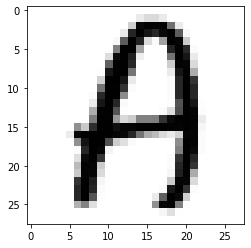

In [34]:
img = x_test[1100]  # random image
imshow_EMNIST(img)

As we said before, the labels will take values between 0 and 46. The correspondence between the labels and the characters is as follows:

| Label | Character |
| --- | --- |
| 0 | '0' |
| **...** | **...** |
| 9 | '9' |
| 10 | 'A' |
| **...** | **...** |
| 35 | 'Z' |
| 36 | 'a' |
| **...** | **...** |
| 46 | 't' |

---

We might think that the conversion of the label into ASCII code would be as simple as carrying out an addition. For example, the label for 'A' is 10, and its ASCII code is 65. So, adding 55 to the label would be enough to get the character.

However, that's quite not right, since there are characters that share the same label, as we can see in the following image extracted from the [EMNIST paper](https://arxiv.org/pdf/1702.05373v1.pdf):

<img src="./img-notebook/EMNIST_dataset.jpg" alt="Balanced EMNSIT Dataset" width="800" align="left" />

This is due to the similarity of certain lowercase and uppercase letters. For example, the characters 'o' and 'O', 'x' and 'X', 'w' and 'W', etc. Telling whether they are lower or uppercase in an isolated context is very complicated, if not impossible.

To establish the correspondence label-character, due to the small irregularities mentioned, the simplest thing to do might be defining a dictionary.

In [35]:
# label-character correspondence
data2ascii = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
              10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
              19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
              28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a',
              37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r',
              46: 't'}

Using the previous example...

Character: A


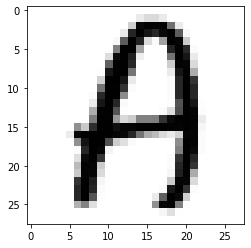

In [36]:
imshow_EMNIST(img)
print("Character:", data2ascii[y_test[1100]])  # y_test stores the labels

It would also be interesting to implement a function that would allow us to find all the occurrences of a certain character in the dataset.

In [37]:
def find_character(character, label_set):
    '''Finds a specific character in a set.

    Args:
        character:
            Character to look for.
        label_set:
            Set containing EMNIST labels.
    
    Returns:
        Indexes where the character has been found.
    '''
    
    pos = []
    for i in range(len(label_set)):
        if data2ascii[label_set[i]] == character:
            pos.append(i)
    return pos

For example, let's look for all the occurrences of 'C':

Number of 'C' characters: 400
[8, 29, 34, 37, 83, 95, 141, 147, 150, 227, 236, 337, 493, 584, 629, 633, 762, 768, 807, 809]


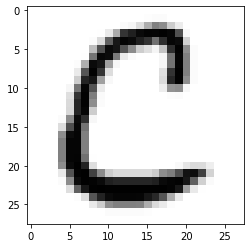

In [310]:
indexes = find_character('C', y_test)

print("Number of 'C' characters:", len(indexes))
print(indexes[:20])

imshow_EMNIST(x_test[indexes[2]])  # third 'C' character in the dataset

---

<a id='section_2'></a>
# 2. Image Pre-processing

The goal of our application is to recognize not only individual characters, but entire words.

To do this, it is necessary to carry out a pre-processing of the image. This pre-processing will basically consist of:

- **Convert the image to grayscale**: we'll convert the image so it has one channel (with values between 0 and 255), instead of three (R, G, B).
- **Binarize the image**: once the image is in grayscale, we'll binarize it so its pixels can only take two values: black *or* white.
- **Segment the image**: then, we'll separate the different characters that make up the word into different images to analyze them individually.
- **Rescale and center the segmented images**: finally, we'll make some transformations to the split images, so that they are as similar as possible to our training set.

Let's go step by step.

---

<a id='section_2_1'></a>
### 2.1 Importing the images

To import the images, we will use three libraries:
- `os`: which let's us interact with the operating system.
- `scikit-image`: which is a powerful image processing library.

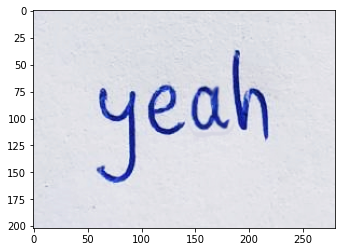

In [356]:
import os
from skimage.io import imread
from pathlib import Path

dataset_dir = Path("./img-prediction")  # directory where the images are
img_names = os.listdir(dataset_dir)  # list all the files in that directory

imgs = []
for name in sorted(img_names):
    img = imread(dataset_dir / name)  # load image
    imgs.append(img)

plt.imshow(imgs[0])  # plot one of the loaded images

---

<a id='section_2_2'></a>
### 2.2 Converting the images to grayscale

Scikit-image provides the `rgb2gray()` method for converting an image to grayscale:

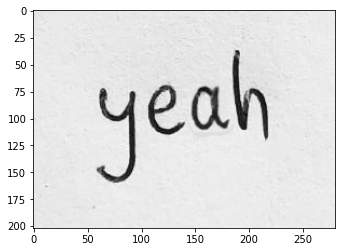

In [169]:
from skimage.color import rgb2gray

img = imgs[0]
img_gray = rgb2gray(img)

plt.imshow(img_gray, cmap='gray')

---

<a id='section_2_3'></a>
### 2.3 Binarizing the images

The next thing we have to do is to binarize the image, that is, to make the pixels of the image take only two values. In our case, we will make those two values 'True' or 'False'.

An important concept when binarizing an image is the *threshold*. Esentially, this value will set the limit between what will be 'True', and what will be 'False'.

Finding a threshold that is versatile enough to adapt to different images can be a complicated task. The scikit-image library provides a number of functions to find an appropriate threshold value. We will use `threshold_otsu()`, based on the [Otsu method](https://en.wikipedia.org/wiki/Otsu%27s_method).

All pixels whose values are below the threshold, will become `True`; the rest, will be `False`. That is, the dark pixels (for example, those that correspond to a letter), will be `True`; the light pixels (the white background), will be `False`.

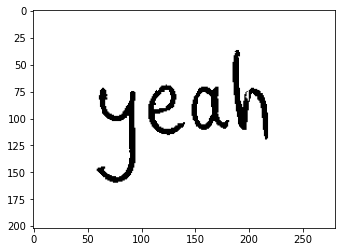

In [170]:
from skimage.filters import threshold_otsu

def binarize(img):
    '''Binarizes an image.
    
    Args:
        img:
            Image to be binarized.
    Returns:
        Binarized image.
    '''
    
    img = rgb2gray(img)
    return img < threshold_otsu(img_gray)  # image binarization
    
img_binary = binarize(img)
    
plt.imshow(img_binary==False, cmap='gray')  # compare with False to have black letters over white bg

---

<a id='section_2_4'></a>
### 2.4 Segmenting the images

To separate the letters that make up the word, we will project the image horizontally and vertically.

We can collect the information from the projections in one-dimensional lists. The values will be boolean, since we just need to know if there is information in a certain column/row of pixels (`True`) or not (`False`).

In [171]:
def get_horiz_projection(img):
    '''Gets the horizontal projections from an image.
    
    Args:
        img:
            Binarized image to get the projections from.
            
    Returns:
        A list containing the horizontal projections.
    '''
    
    img_width = img.shape[1]
    h_proj = np.empty(img_width, dtype=bool)
    for i in range(img_width):
        h_proj[i] = any(img[..., i])  # True if there's information in a column
    return h_proj

def get_vert_projection(img):
    '''Gets the vertical projections from an image.
    
    Args:
        img:
            Binarized image to get the projections from.
            
    Returns:
        A list containing the vertical projections.
    '''
    
    img_height = img.shape[0]
    v_proj = np.empty(img_height, dtype=bool)
    for i in range(img_height):
        v_proj[i] = any(img[i])
    return v_proj

In [360]:
get_horiz_projection(img_binary)[103:111]  # check it works

array([False, False, False, False,  True,  True,  True,  True])

Once we know where there's information, and where there's not, thanks to the functions defined above, we want to know in which pixel intervals the information is contained. We can store the start and end points of the information in a list, as illustrated below:

<img src="./img-notebook/projection.jpg" alt="List with the horizontal projections" width="400" align="left" />

In [173]:
def get_slices_from_proj(img, f_projection, elem_sub_list = 0):
    '''Returns a list of projection intervals in which there is
       information.    
    
    Args:
        img:
            Binarized image to get the slices from.  
        f_projection:
            Function that calculates the projections.
        elem_sub_list:
            Used to divide the list in sublists of `elem_sub_list`
            elements.
            
    Returns:
        The list with the pixel intervals.
    '''
    
    slices = []
    proj = f_projection(img)
    previous = proj[0]
    for i in range(1, proj.size):
        if previous != proj[i]:  # we keep track of the pixel where there's change
            slices.append(i)
            previous = proj[i]  # update previous
    return slices if not elem_sub_list else sub_list(slices, elem_sub_list)

def sub_list(main_list, elem_sub_list):
    '''
    Create sublists of `elem_sub_list` elements inside `main_list`.

    Args:
        main_list:
            List that will to be divided into sublists.
        elem_sub_list:

    Returns:
        The list with the sublists created.
    '''
    return [main_list[i:i+elem_sub_list] for i in range(0, len(main_list), elem_sub_list)]

In [174]:
get_slices_from_proj(img_binary, get_horiz_projection, 2)

[[59, 95], [107, 141], [147, 182], [185, 218]]

With this information, we are now able to segment the image:

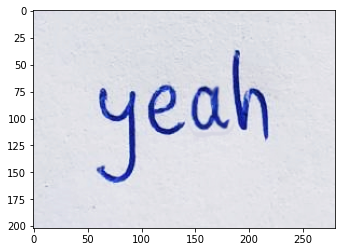

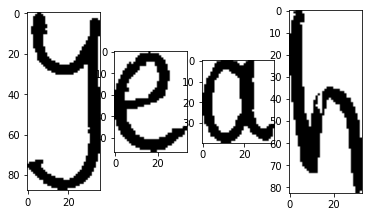

In [175]:
imgs_crop = []
h_slices = get_slices_from_proj(img_binary, get_horiz_projection, 2)
for i in range(len(h_slices)):
    imgs_crop.append(img_binary[:, h_slices[i][0] : h_slices[i][1]])  # crop left and right
for i in range(len(imgs_crop)):
    v_slices = get_slices_from_proj(imgs_crop[i], get_vert_projection)  # take the vertical projection of each
    imgs_crop[i] = imgs_crop[i][v_slices[0]:v_slices[-1]]               # letter and crop top and bottom

plt.imshow(img)

# Plot the separated letters
f, axarr = plt.subplots(1, 4) # creamos la figura y los ejes
axarr[0].imshow(imgs_crop[0]==False, cmap='gray')
axarr[1].imshow(imgs_crop[1]==False, cmap='gray')
axarr[2].imshow(imgs_crop[2]==False, cmap='gray')
axarr[3].imshow(imgs_crop[3]==False, cmap='gray')

---

<a id='section_2_5'></a>
### 2.5 Rescaling and center the segmented images

The resizing of the images can be done with the help of the `resize()` function from `scikit-image`. In order to avoid pixelated edges when resizing, we will first apply a Gaussian filter. Again, `scikit-image` provides a suitable function for this: `gaussian()`.

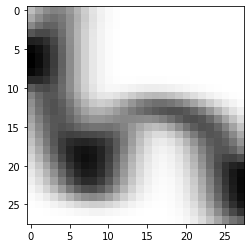

In [176]:
from skimage.filters import gaussian
from skimage.transform import resize

img_blur = gaussian(imgs_crop[3], 3)  # Gaussian blur for smooth edges when rescaling
img_resized = resize(img_blur, (28, 28), mode='reflect', anti_aliasing=True)  # rescale to 28 x 28

plt.imshow(255-img_resized, cmap='gray')

To prevent the image from being distorted and the edges of the letter from sticking to the edge of the image, we will add a white frame around it, so that the letter is nicely centered in the image.

We will define a function that will add these borders and resize the image.

In [177]:
def add_borders_resize(img, pxls_width = 28, pxls_height = 28, sigma=0.3):
    '''Adds white borders to the image and scales it to `pxls_width`
       by `pxls_height` pixels.
       
    Args:
        img:
            Image that will have the borders added to, and will be
            rescaled.
        pxls_width:
            Width of the resized image in pixels.
        pxls_height:
            Height of the resized image in pixels.
        sigma:
            Deviation for the Gaussian filter.

    Returns:
        The resized image with the added frames.
    '''
    
    if img.shape[0] > img.shape[1]:  # if the image is higher than it is wide
        # order_height and border_width are added above and below, left and right, respectively
        border_height = int((img.shape[1]/img.shape[0])*(pxls_width/1.1))  # arbitrary (the higher the image
                                                                           # is, the less border we should add)
        # border_width is calculated so that when it is added to the image, it becomes square
        border_width = int(((img.shape[0]+border_height*2) - img.shape[1])/2)
    else:  # if the image is wider than it is higher, the process is similar
        border_width = int((img.shape[0]/img.shape[1])*(pxls_width/1.1)) # arbitrary
        border_height = int(((img.shape[1]+border_width*2) - img.shape[0])/2)
    v_border = []  # vertical border
    for i in range(border_height):
        v_border.append([False for i in range(0, img.shape[1])])  # create vertical border
    img = np.concatenate((np.asarray(v_border), img, np.asarray(v_border)))  # add it to left and right of the img
    h_border = []  # horizontal border
    for i in range(0, img.shape[0]):
        h_border.append([False for i in range(0, border_width)])  # create horizontal border
    img = np.column_stack((np.asarray(h_border), img, np.asarray(h_border))) # add it above and below
    img = gaussian(img, sigma*10)  # Gaussian blur
    # rescale and normalize to 0-255
    return (resize(img,(pxls_width, pxls_height), mode='reflect', anti_aliasing=True)*255).astype(int)

When returning, the image is normalized so that all its values are between 0 and 255 and are of type `int`, just like the samples of our dataset. This is necessary since the `gaussian ()` function returns the image in `float` values between 0.0 and 1.0.

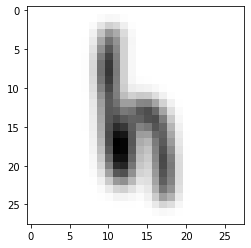

In [178]:
img_resized = add_borders_resize(img_blur)

plt.imshow(255-img_resized, cmap='gray')

Let's create a function that segments the letters of the word, resizes them, and adds the white border to each of them:

In [179]:
def slice_image(img):
    '''Slices the letters in the image.
    
    Args:
        img:
            Image to be sliced.
    Returns:
        A list with the slices.
    '''
    
    imgs_crop = []
    h_slices = get_slices_from_proj(img, get_horiz_projection, 2)
    for i in range(len(h_slices)):
        imgs_crop.append(img[:, h_slices[i][0] : h_slices[i][1]])  # crop left and right
    for i in range(len(imgs_crop)):
        v_slices = get_slices_from_proj(imgs_crop[i], get_vert_projection)  # we take the vertical projection of
        imgs_crop[i] = imgs_crop[i][v_slices[0]:v_slices[-1]]               # each letter and crop top and bottom
        imgs_crop[i] = add_borders_resize(imgs_crop[i])  # rescale and add frame
    return imgs_crop

---

<a id='section_2_6'></a>
### 2.6 Bringing everything together...

Finally, we will define a function that gathers all the steps involved in the pre-processing of the image:

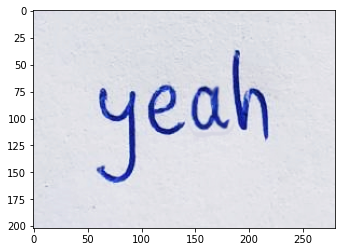

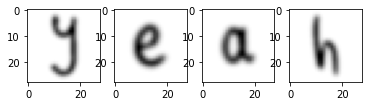

In [180]:
def pre_process_img(img):
    '''Pre-processes and slices the image.
    
    Args:
        img:
            Image to be pre-processed.
            
    Returns:
        The image pre-processed and sliced.
    '''
    
    img_binary = binarize(img)  # binarize the image
    imgs_sliced = slice_image(img_binary)  # slice the image
    return imgs_sliced

def imshow_segmented(img, imgs_crop):
    '''Plots the original image, as well as its slices once
       pre-processed.
    
    Args:
        img:
            Image to be plotted.
        imgs_crop:
            Image slices.
    '''
    plt.imshow(img)
    # plot the letters separately
    f, axarr = plt.subplots(1, len(imgs_crop))
    for i in range(len(imgs_crop)):
        axarr[i].imshow(255-imgs_crop[i], cmap='gray')

imgs_sliced = pre_process_img(img)
imshow_segmented(img, imgs_sliced)

---

<a id='section_3'></a>
# 3. Prediction

To predict the letters, we will use a neural network as a classifier. The `scikit-learn` library provides us with multiple alternatives when it comes to classifiers. We will use the `MLPClassifier`, a classifier that implements a multilayer perception.

This classifier supports numerous hyper-parameters that we can adjust to achieve better prediction. In our case, we will only define the number of hidden layers and neurons, but you can try more advanced configurations to improve its accuracy.

In [181]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(1024, 512, 256))

---

<a id='section_3_1'></a>
### 3.1 Training our model

To train the classifier, since we already defined our training sets in [Section 1](#section_1), we only need to call our classifier `fit` method.

In [182]:
# clf.fit(x_train, y_train)

Once our model is trained, we can save it so we don't lose it when we close the notebook. To do this, we are going to use the `pickle` library, which also allows us to load a pre-trained classifier.

In [183]:
import pickle

'''
# save the trained classifier
with open('pretrained-models/mlp_classifier.pkl', 'wb') as fid:
    pickle.dump(clf, fid)  
'''

# load the saved classifier
with open(Path('pretrained-models/mlp_classifier.pkl'), 'rb') as fid:
    clf = pickle.load(fid)

---

<a id='section_3_2'></a>
### 3.2 Measuring the accuracy

Once we have trained our model, we will measure its accuracy. Let's define a function for that:

In [184]:
def clf_accuracy(x_test, y_test):
    '''Calculates a classifier accuracy.
    
    Args:
        x_test:
            The input test features.
        y_test:
            The input test labels.
            
    Returns:
        The accuracy of the model.
    '''
    
    p = clf.predict(x_test)
    count = 0
    
    for p_i, y_i in zip(p, y_test):
        count +=  int(p_i == y_i)
         
    return (count / x_test.shape[0]) * 100

print("Accuracy:", clf_accuracy(x_test, y_test))

Accuracy: 82.54162455449759


---

<a id='section_3_3'></a>
### 3.3 Predicting words

Finally, we can try to predict our own words. Let's define a function that joins everything we have seen so far:

In [185]:
def get_prediction(img, clf, case='first'):
    '''Predicts the word in the image.
    
    Args:
        img:
            The photo with the word to identify.
        clf:
            The classifier used for the prediction.
        case:
            Optional. Admissible values are:
                - 'first': capitalize first letter.
                - 'upper': capitalize whole word.
                - If any other value is passed, including the empty
                  string, the word will be returned in lower case.
    
    Returns:
        The predicted word.
    '''
    
    preds = []
    for image in pre_process_img(img):
        image = np.rot90(image, k=-1)  # rotate and mirror the image,
        image = np.fliplr(image)       # so it matches the dataset images
        image = image.reshape(image.size).tolist()
        pred = clf.predict([image])[0]
        preds.append(data2ascii[pred])
    word = "".join(preds)
    if case == 'first':
        return word.capitalize()
    elif case == 'upper':
        return word.upper()
    return word.lower()

---

<a id='section_3_3_1'></a>
#### 3.3.1 Image #1

Predicción: yeah


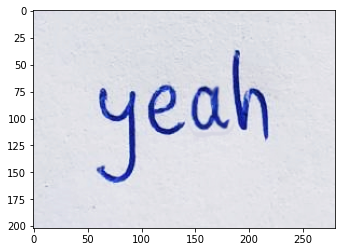

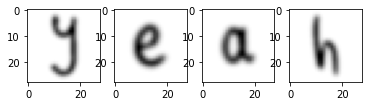

In [186]:
img = imgs[0]

word = get_prediction(img, clf, case='lower')
print("Prediction:", word)

imshow_segmented(img, pre_process_img(img))

---

<a id='section_3_3_2'></a>
#### 3.3.2 Image #2

Predicción: great


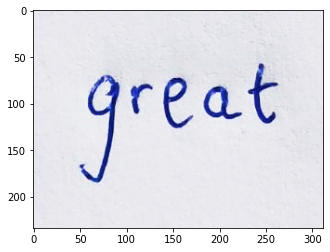

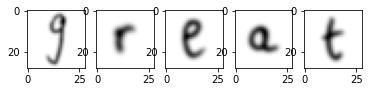

In [187]:
img = imgs[1]

plt.imshow(img)

word = get_prediction(img, clf, case='lower')
print("Prediction:", word)

imshow_segmented(img, pre_process_img(img))

---

<a id='section_3_3_3'></a>
#### 3.3.3 Image #3

Prediction: 4chan


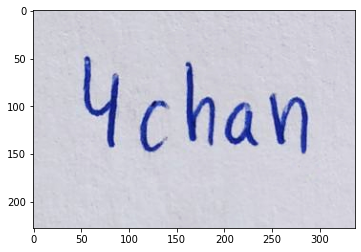

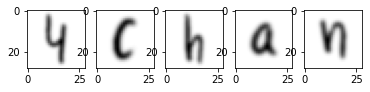

In [191]:
img = imgs[2]

plt.imshow(img)

word = get_prediction(img, clf)
print("Prediction:", word)

imshow_segmented(img, pre_process_img(img))

---

<a id='section_3_3_4'></a>
#### 3.3.4 Image #4

Prediction: understanding


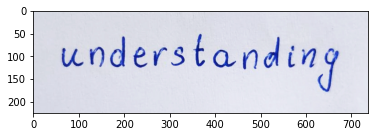

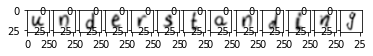

In [258]:
img = imgs[3]

plt.imshow(img)

word = get_prediction(img, clf, case='lower')
print("Prediction:", word)

imshow_segmented(img, pre_process_img(img))

---

<a id='section_3_3_5'></a>
#### 3.3.5 Image #5

Prediction: h4ck3rm4n


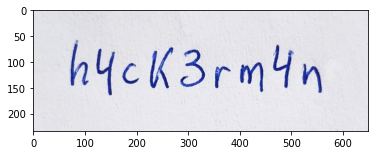

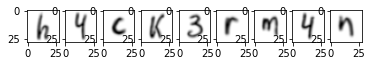

In [266]:
img = imgs[4]

plt.imshow(img)

word = get_prediction(img, clf, case='lower')
print("Prediction:", word)

imshow_segmented(img, pre_process_img(img))

---

---

<a id='section_3_3_6'></a>
#### 3.3.5 Image #6

Prediction: Incomprehensibi1ities


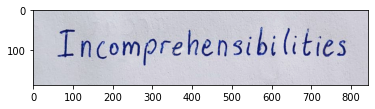

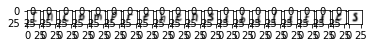

In [352]:
img = imgs[5]

plt.imshow(img)

word = get_prediction(img, clf)
print("Prediction:", word)

imshow_segmented(img, pre_process_img(img))

---

**Note**: You might have thought that the previous examples are cherry-picked... Well... you're somehow right ;) But hey, we trained a very basic classifier, so it's not that bad, is it? That's why I challenge you to train better models, you might get much better results! You can learn more about the Multi-layer Perceptron (MLP) and `scikit-learn`'s implementation of it [here](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).

---

<a id='section_4'></a>
# 4. Conclusion and possible improvements

In this notebook we have explained a simple implementation of Handwritten Recognition (HWR), covering the pre-processing of the images, the training of a simple classifier, and last but not least, we have tested the whole thing with real-world examples.

One important thing to notice is that our implementation, because of being so simple, has some *serious* limitations. For example, because of the way we separate the letters (through projections), our algorithm would be unable to separate letters that are joined together, something that happens frequently in handwriting.

As for possible improvements, there would be quite some of them, although the most immediate would be:

- **Train a more accurate classifier**: Currently, our model has an accuracy slightly below 83%. We have trained it with a very basic configuration, without specifying any other hyper-parameters apart from the hidden layers. Achieving better values shouldn't be too complicated with a more thorough model definition.


- **Detect whitespaces**: For now, our algorithm is not able to detect spaces. If it was able to do so, we would be able to predict whole sentences. The detection of whitespaces could be carried out in a statistical by measuring the mean distance between letters, and detecting the outliers according to that calculated value. These outliers would indicate the existence of a whitespace, and not just a separation between the letters of a word.

<a id='section_5'></a>
## 5. References and further reading

<a id='ref_1'>[1]</a> Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373.

- Birbek, E. *How To Build a Neural Network to Recognize Handwritten Digits with TensorFlow*. https://www.digitalocean.com/community/tutorials/how-to-build-a-neural-network-to-recognize-handwritten-digits-with-tensorflow. [Last accessed: December 10, 2020].


- Pathak, A. *Handwritten Digits Recognition in python using scikit-learn*. https://www.youtube.com/watch?v=aZsZrkIgan0. [Last accessed: December 10, 2020].

[Back to the begining](#title)